In [30]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Data_processing')
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_predict, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_curve,make_scorer, auc, roc_auc_score, precision_recall_curve, brier_score_loss, top_k_accuracy_score, balanced_accuracy_score, cohen_kappa_score, log_loss, PrecisionRecallDisplay, accuracy_score, precision_score, recall_score, precision_recall_curve, RocCurveDisplay, ConfusionMatrixDisplay, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pyvis.network import Network
from data_processing import KOProcessor
from bioservices import KEGG
import warnings
from joblib import Memory
from sklearn.calibration import calibration_curve
from itertools import cycle
from sklearn.exceptions import NotFittedError
from scipy.stats import entropy
sns.set_palette('crest')
warnings.filterwarnings('ignore')

In [31]:
# ADded changes for pipeline to run quicker, should equal 55 fits
 
param_grid = [
    {  
        'estimator': [MultiOutputClassifier(RandomForestClassifier(random_state=42))],
        'estimator__estimator__n_estimators': [100, 300],  # Reduced from [100, 200, 300]  
        'estimator__estimator__max_depth': [5, None]  # Reduced from [5, 10, 15, None]
    },
    {  
        'estimator': [MultiOutputClassifier(SVC(random_state=42, probability=True))],
        'estimator__estimator__C': [0.1, 1],  # Reduced from [0.1, 1, 10]
        'estimator__estimator__kernel': ['linear', 'rbf'], 
        'estimator__estimator__gamma': ['scale']  # Removed 'auto'
    },
    {
        'estimator': [MultiOutputClassifier(LogisticRegression())],
        'estimator__estimator__C': [0.1, 1, 10]  # Reduced from [0.01, 0.1, 1, 10, 100]
    }         
]

target_traits = ['trophy']  # Add/remove traits as needed

In [32]:
# Load and preprocess data
terms_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/terms_KO.zip'
terms_csv_path = 'terms_KO.csv'
traits_reduced_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/reducedDataset.zip'
traits_reduced_csv_path = 'reducedDataset.csv'
traits_assembled_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/assembledDataset.zip'
traits_assembled_csv_path = 'assembledDataset.csv'

processor = KOProcessor(
    terms_zip_path, 
    terms_csv_path, 
    traits_reduced_zip_path, 
    traits_reduced_csv_path, 
    traits_assembled_zip_path=traits_assembled_zip_path, 
    traits_assembled_csv_path=traits_assembled_csv_path
)

ko_terms = processor.load_terms()
if ko_terms is None:
    raise FileNotFoundError("KO terms could not be loaded. Please check the file paths.")

reduced_traits_data = processor.load_reduced_traits_data()
if reduced_traits_data is None:
    raise FileNotFoundError("Reduced traits data could not be loaded. Please check the file paths.")

min_samples=4

# Preprocess KO terms
X_terms  = processor.preprocess_terms(ko_terms)


##################
# Removing rare KO terms >2 samples
##################

y_str_dfs = []
y_int_dfs = []
for trait in target_traits:
    y_trait = processor.preprocess_traits(
        reduced_traits_data,
        trait_column=trait,
        use_assembled_if_missing=True
    )
    if y_trait is None:
        continue
    
    # keep the raw string labels
    y_str_dfs.append(pd.Series(y_trait, index=y_trait.index, name=trait))
    
    # initial integer encoding (for filtering step)
    le0   = LabelEncoder().fit(y_trait)
    y_int = le0.transform(y_trait)
    y_int_dfs.append(pd.Series(y_int, index=y_trait.index, name=trait))

# combine into DataFrames, drop NA
Y_str = pd.concat(y_str_dfs, axis=1).dropna()
Y_int = pd.concat(y_int_dfs, axis=1).dropna()

# ——— 2) Align X and Y_int, then drop “rare” integer codes ———
X0, Y0 = processor.align_data(X_terms, Y_int)

# find rare integer codes
to_drop = {}
for trait in Y0.columns:
    freq = Y0[trait].value_counts()
    rare = freq[freq < min_samples].index.tolist()
    if rare:
        to_drop[trait] = rare
        print(f"Trait '{trait}': dropping codes {rare} (<{min_samples} samples)")

# build mask, filter both X0 and Y0, and string DF
mask           = pd.Series(True, index=Y0.index)
for trait, rares in to_drop.items():
    mask &= ~Y0[trait].isin(rares)

X_filtered     = X0.loc[mask]
Y_int_filtered = Y0.loc[mask]
Y_str_filtered = Y_str.loc[mask]

print(f"\nAfter filtering: {len(Y_int_filtered)} samples remain.")

# ——— 3) Re-fit fresh encoders on the **filtered strings** ———
label_encoders = {}
for trait in target_traits:
    le = LabelEncoder().fit(Y_str_filtered[trait])
    label_encoders[trait] = le

# rebuild the final integer DataFrame
Y_aligned = pd.DataFrame({
    trait: label_encoders[trait].transform(Y_str_filtered[trait])
    for trait in target_traits
}, index=Y_str_filtered.index)

# ——— 4) Verify cleaned distributions ———
for trait in target_traits:
    print(f"\nCleaned Distribution for '{trait}':")
    counts = Y_aligned[trait].value_counts().sort_index()
    le     = label_encoders[trait]
    for code, cnt in counts.items():
        human = le.inverse_transform([code])[0]
        print(f"  {human:<25} (code={code:>2}): {cnt} samples")

#############
# Done with removing rare KO terms
#############

# Now continue with feature‐selection 
original_features = X_filtered.columns  # Store feature names before threshold
selector   = VarianceThreshold(threshold=0.02)
X_aligned = selector.fit_transform(X_filtered)
selected_features = original_features[selector.get_support()]
print(f"Features reduced from {len(original_features)} to {len(selected_features)}")

Data loaded successfully:
   Unnamed: 0   key      KO
0           0  1000  K00001
1           1  1000  K13954
2           2  1000  K00003
3           3  1000  K00013
4           4  1000  K00014
Data loaded successfully:
   key  ...                                        ncbiFTP_FAA
0    1  ...  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...
1    1  ...  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...
2    2  ...  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...
3    3  ...  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...
4    4  ...  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/9...

[5 rows x 18 columns]
Data loaded successfully:
   Unnamed: 0 database  ...  ref                                        genomeAccNo
0           0  bacdive  ...  NaN                                                NaN
1           1  bacdive  ...  NaN  GCA_000193495|GCA_002005445|GCA_004341595|GCA_...
2           2  bacdive  ...  NaN                                                NaN
3           3  ba


>>> Computing MCC distributions for trait 'trophy'

Top 10 |MCC| for trophy = 'chemoheterotroph':
Feature       MCC
 K02438  0.447474
 K01372  0.384241
 K03201  0.366845
 K01392  0.366845
 K01354  0.333333
 K03197  0.332545
 K07343  0.328384
 K13589  0.325319
 K03546 -0.318878
 K19746  0.315015


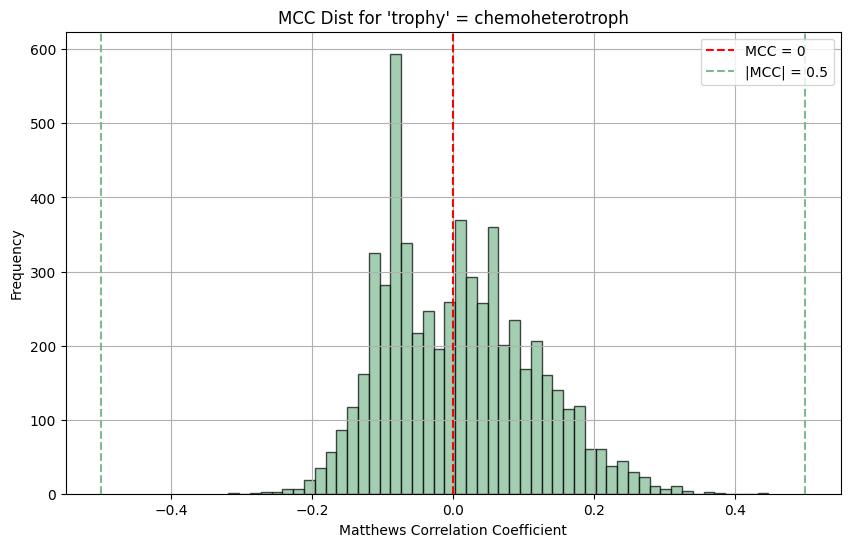

Top 10 |MCC| for trophy = 'chemolithoautotroph':
Feature      MCC
 K16887 0.650151
 K16886 0.586556
 K03388 0.557570
 K11181 0.546779
 K11180 0.546779
 K00534 0.546779
 K21307 0.535570
 K16885 0.517677
 K21563 0.503653
 K09126 0.493154


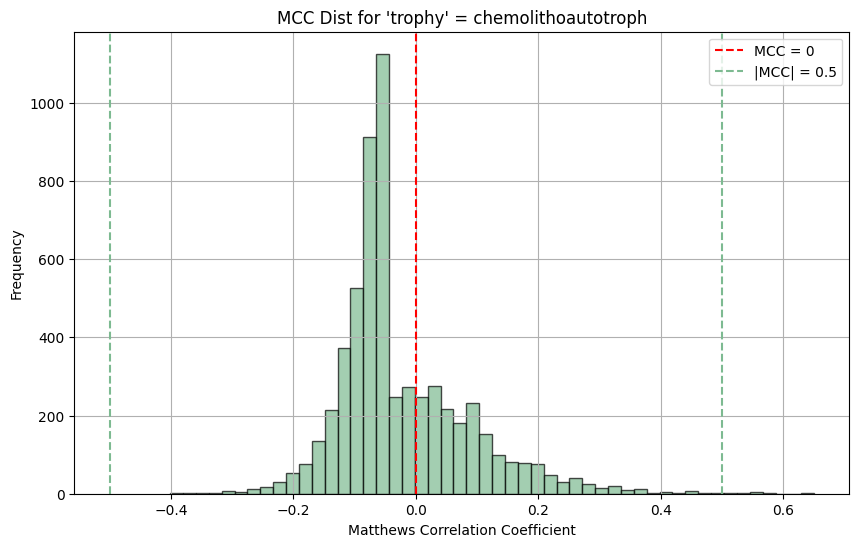

Top 10 |MCC| for trophy = 'chemoorganoheterotroph':
Feature      MCC
 K09859 0.437885
 K13893 0.393573
 K05338 0.374021
 K18248 0.364195
 K03779 0.364195
 K07337 0.352312
 K05886 0.335549
 K15383 0.333996
 K22015 0.320085
 K07062 0.308553


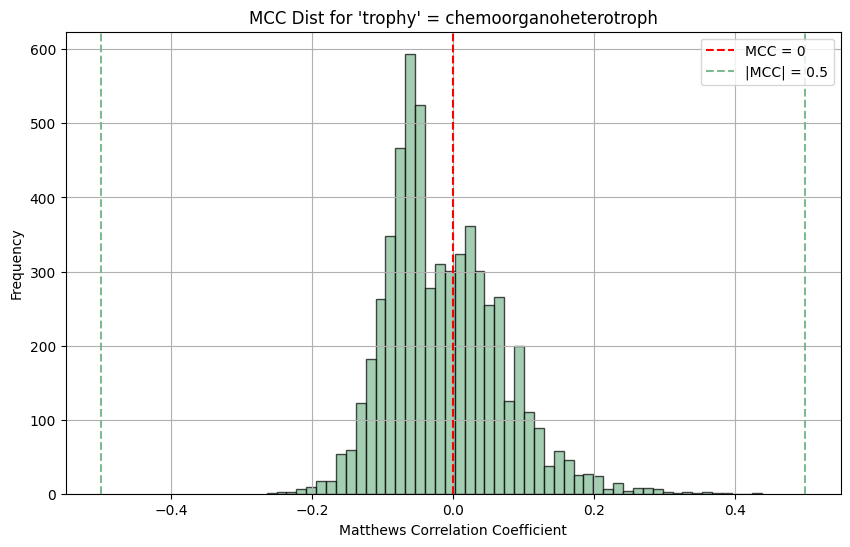

Top 10 |MCC| for trophy = 'chemoorganotroph':
Feature      MCC
 K01090 0.403135
 K07173 0.370214
 K07586 0.370214
 K03324 0.368215
 K16167 0.360069
 K03610 0.335675
 K07533 0.330348
 K16168 0.328226
 K14540 0.322907
 K14660 0.318590


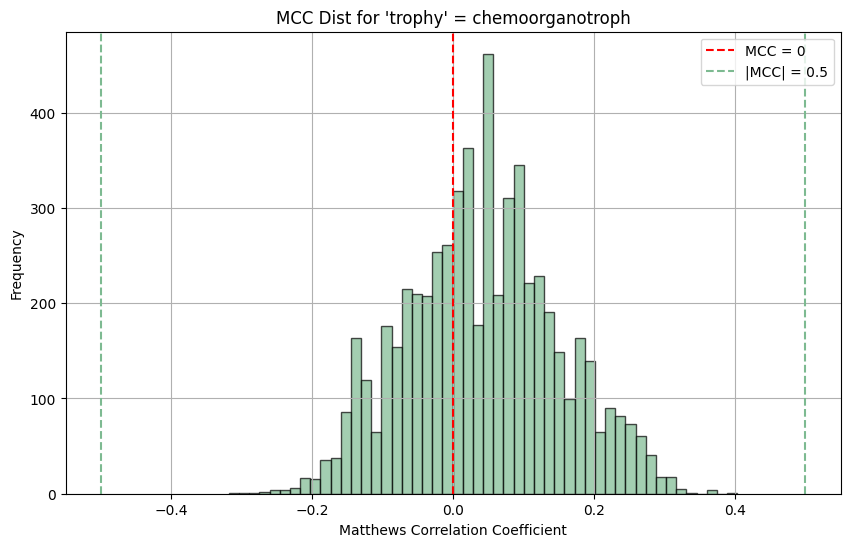

Top 10 |MCC| for trophy = 'heterotroph':
Feature       MCC
 K00989 -0.486129
 K07042 -0.485931
 K03060 -0.472765
 K06173 -0.446397
 K03216 -0.419443
 K03113  0.401082
 K00648 -0.400951
 K00764 -0.394400
 K07738 -0.394400
 K02502 -0.392938


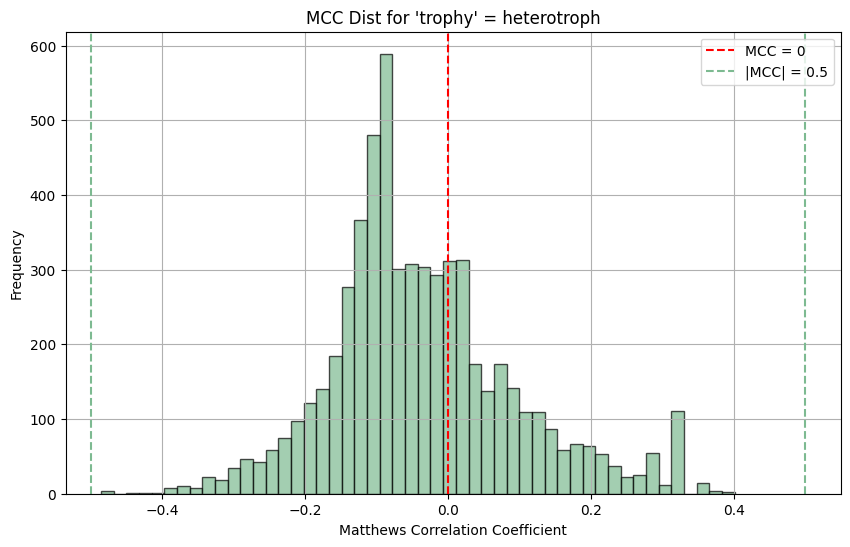

Top 10 |MCC| for trophy = 'methylotroph':
Feature      MCC
 K07155 0.743243
 K08692 0.743243
 K10714 0.743243
 K10713 0.697486
 K11081 0.599889
 K00613 0.599889
 K15546 0.552141
 K21679 0.552141
 K01499 0.537570
 K21678 0.513427


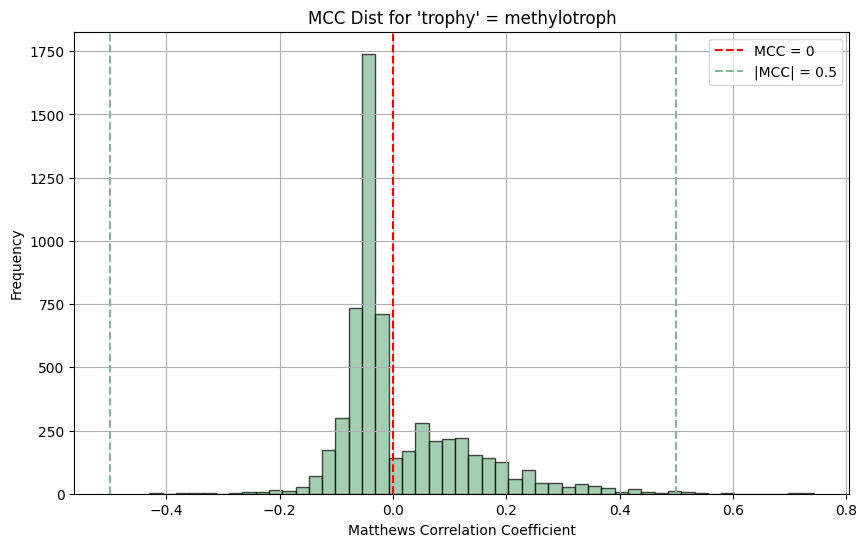

In [33]:
# Grab the original X (with column names) back:
orig_X, _ = processor.align_data(X_terms, Y_int)

# Get the boolean mask of features kept by VarianceThreshold:
mask = selector.get_support()

# Extract those feature names:
feature_names = orig_X.columns[mask]

# Rebuild a DataFrame so we can iterate over feature columns:
X_sel_df = pd.DataFrame(X_aligned, columns=feature_names)

# One-vs-rest MCC for each sublabel of each multi-class trait
ovr_mcc_results = {}

for target_trait in target_traits:
    print(f"\n>>> Computing MCC distributions for trait '{target_trait}'\n")

    # Get the encoder & the aligned column
    le = label_encoders[target_trait]
    y_col = Y_aligned[target_trait]

    # Mask out constant columns
    mask = selector.get_support()
    orig_X, _ = processor.align_data(X_terms, Y_int)
    feature_names = orig_X.columns[mask]
    X_sel_df = pd.DataFrame(X_aligned, columns=feature_names)

    # Loop each sublabel and treat as binary
    for encoded_label in np.unique(y_col):
        label_name = le.inverse_transform([encoded_label])[0]
        y_bin = (y_col == encoded_label).astype(int).values

        # Skip if no variance
        if y_bin.sum() == 0 or y_bin.sum() == len(y_bin):
            print(f"Skipping '{label_name}': no variance")
            continue

        # Compute MCC for each feature
        mccs = [matthews_corrcoef(y_bin, X_sel_df[feat].values)
                for feat in X_sel_df.columns]

        # Assemble & sort
        df = pd.DataFrame({
            'Feature': X_sel_df.columns,
            'MCC':     mccs
        })
        df['abs_mcc'] = df['MCC'].abs()
        df = df.sort_values('abs_mcc', ascending=False).drop(columns='abs_mcc')
        ovr_mcc_results[(target_trait, label_name)] = df

        # Print top 10
        print(f"Top 10 |MCC| for {target_trait} = '{label_name}':")
        print(df.head(10).to_string(index=False))

        # Plot distribution
        vals = df['MCC'].dropna()
        plt.figure(figsize=(10,6))
        plt.hist(vals, bins=50, edgecolor='black', alpha=0.7)
        plt.title(f"MCC Dist for '{target_trait}' = {label_name}")
        plt.axvline(0, color ='red',  linestyle='--', label='MCC = 0')
        plt.axvline(0.5, linestyle='--', label='|MCC| = 0.5')
        plt.axvline(-0.5, linestyle='--')
        plt.xlabel('Matthews Correlation Coefficient')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

In [34]:
#############################################
# Modified Functions for Multi-Output
#############################################

def plot_cv_indices(cv, X, y, ax, lw=6):
    """
    Plot train/test indices for each split of a CV iterator.
    Training indices in blue, testing in red.
    """
    for ii, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        # blue ticks for train, red for test
        ax.scatter(train_idx, [ii]*len(train_idx), marker='_', c='C0', lw=lw)
        ax.scatter(test_idx, [ii]*len(test_idx), marker='_', c='C3', lw=lw)
    ax.set_ylabel('CV iteration')
    ax.set_xlabel('Sample index')
    ax.set_title(f'{type(cv).__name__} splits')

def plot_advanced_confusion_matrix(y_true, y_pred, classes, title):
    """Enhanced confusion matrix with normalization and counts"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='crest',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Normalized Confusion Matrix\n{title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Add raw counts to bottom
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xticklabels([str(int(x)) for x in cm.sum(axis=0)])
    ax2.set_xlabel('Total Predictions')
    plt.show()

def plot_roc_curves(y_true, y_probs, classes, title):
    """Multiclass ROC curves with AUC scores"""
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all classes
    plt.figure(figsize=(10, 8))
    colors = cycle(sns.color_palette('crest', n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {title}')
    plt.legend(loc="lower right")
    plt.show()

def plot_class_probabilities(y_probs, classes, title):
    """Violin plot of class probability distributions"""
    prob_df = pd.DataFrame(y_probs, columns=classes)
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=prob_df, inner="quartile", palette="Set3")
    plt.title(f'Class Probability Distributions\n{title}')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.show()

def plot_svm_feature_importance(svm_model, feature_names, top_n=20, title=""):
    """Plot feature importance for SVM using raw coefficient magnitudes (sorted descendingly)"""
    # Get coefficients (works for linear SVM)
    coefficients = svm_model.coef_
    
    # For multi-class, average absolute coefficients across classes
    if len(coefficients.shape) > 1:
        importances = np.mean(np.abs(coefficients), axis=0)
    else:
        importances = np.abs(coefficients)
    
    # Sort indices in DESCENDING order (most important first)
    indices = np.argsort(importances)[::-1][:top_n]
    
    plt.figure(figsize=(12, 8))
    plt.bar(range(top_n), importances[indices], color="C1", align="center")
    plt.xticks(range(top_n), [feature_names[i] for i in indices], 
               rotation=45, ha="right")
    plt.xlim([-1, top_n])
    plt.title(f"SVM Feature Importance (Coefficient Magnitude)\n{title}", fontsize=14)
    plt.ylabel("Mean Absolute Coefficient", fontsize=12)  # Updated y-axis label
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(forest, feature_names, top_n=20, title=""):
    """Plot feature importance with MDI (Mean Decrease in Impurity)"""
    importances = np.mean([estimator.feature_importances_ for estimator in forest.estimators_], axis=0)
    std = np.std([estimator.feature_importances_ for estimator in forest.estimators_], axis=0)
    
    # Sort in descending order and get top N
    indices = np.argsort(importances)[::-1][:top_n]
    
    plt.figure(figsize=(12, 8))
    plt.bar(range(top_n), importances[indices], 
            color="C0", yerr=std[indices], align="center")
    plt.xticks(range(top_n), [feature_names[i] for i in indices], 
             rotation=45, ha="right")
    plt.xlim([-1, top_n])
    plt.title(f"Feature Importances (MDI)\n{title}", fontsize=14)
    plt.ylabel("Mean Decrease in Impurity", fontsize=12)
    plt.grid(True, axis='y', alpha=0.3)
    
    # Invert y-axis to show highest at top when using horizontal
    # For vertical bars, add descending order labels instead:
    plt.gca().invert_yaxis() if horizontal else None  # Remove if vertical
    
    plt.tight_layout()
    plt.show()

def plot_prediction_errors(y_true, y_pred, classes, title):
    """Error analysis: which classes are confused with others"""
    error_matrix = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(error_matrix, 0)  # Remove correct predictions
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(error_matrix, annot=True, fmt='d', cmap='crest',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Prediction Errors\n{title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def decode_labels(Y, label_encoders):
    """Convert numerical labels back to original text labels"""
    decoded = Y.copy()
    for trait in Y.columns:
        decoded[trait] = label_encoders[trait].inverse_transform(Y[trait])
    return decoded

# =============================================
#  Probability Trustworthiness Functions
# =============================================

def plot_calibration_curves(y_true, y_proba, classes, title):
    """Add this after existing plotting functions"""
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(classes):
        true_binary = (y_true == i).astype(int)
        prob_pos = y_proba[:, i]
        fraction_of_positives, mean_predicted_value = calibration_curve(
            true_binary, prob_pos, n_bins=10, strategy='quantile'
        )
        plt.plot(mean_predicted_value, fraction_of_positives, 's-', 
                label=f'{class_name}')

    plt.plot([0, 1], [0, 1], 'k:', label='Perfect')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positive Samples')
    plt.title(f'Calibration: {title}')
    plt.legend(loc='lower right')
    plt.show()

def calculate_brier_scores(y_true, y_proba, classes):
    """Add this with other metric functions"""
    scores = {}
    for i, class_name in enumerate(classes):
        true_binary = (y_true == i).astype(int)
        scores[class_name] = brier_score_loss(true_binary, y_proba[:, i])
    return pd.DataFrame.from_dict(scores, orient='index', columns=['Brier Score'])

def analyze_prediction_entropy(y_proba, classes):
    """Enhanced with uncertainty samples identification"""
    entropies = np.array([entropy(probs) for probs in y_proba])
    
    plt.figure(figsize=(12, 6))
    ax = sns.histplot(entropies, bins=30, kde=True)
    
    # Add uncertainty thresholds
    low_uncertainty = np.log(len(classes)) * 0.3
    high_uncertainty = np.log(len(classes)) * 0.7
    ax.axvline(x=low_uncertainty, color='g', linestyle='--', label='Low uncertainty')
    ax.axvline(x=high_uncertainty, color='r', linestyle='--', label='High uncertainty')
    
    plt.title('Prediction Entropy Distribution')
    plt.xlabel('Entropy (Higher = More Uncertainty)')
    plt.legend()
    plt.show()
    
    # Return indices of uncertain samples
    return np.where(entropies > high_uncertainty)[0]

def check_probability_consistency(y_proba, y_pred, classes):
    """Verify predicted class matches highest probability"""
    mismatches = 0
    for i in range(len(y_pred)):
        if not np.isclose(y_proba[i, y_pred[i]], np.max(y_proba[i])):
            mismatches += 1
    print(f"\nProbability consistency: {100*(1-mismatches/len(y_pred)):.2f}% match")

def validate_probabilities(y_proba, y_pred):
    """Check probability validity with tolerance"""
    # Check probability sums
    if not np.allclose(y_proba.sum(axis=1), 1.0, atol=0.01):
        print("Warning: Probabilities don't sum to 1 ±0.01")
    
    # Check prediction consistency
    mismatch_mask = y_pred != np.argmax(y_proba, axis=1)
    mismatch_rate = np.mean(mismatch_mask)
    
    if mismatch_rate > 0:
        print(f"Warning: {mismatch_rate:.2%} predictions don't match max probabilities")
        print("Sample mismatches:")
        for i in np.where(mismatch_mask)[0][:3]:  # Show first 3
            print(f"Sample {i}: Predicted {y_pred[i]}, Max prob at {np.argmax(y_proba[i])}")

def plot_confidence_distribution(y_proba, title):
    """Distribution of maximum class probabilities"""
    max_probs = np.max(y_proba, axis=1)
    plt.figure(figsize=(10, 5))
    sns.histplot(max_probs, bins=20, kde=True)
    plt.title(f'Prediction Confidence: {title}')
    plt.xlabel('Maximum Class Probability')
    plt.show()

def find_ambiguous_samples(y_proba, threshold=0.1):
    """Identify samples where top-2 classes are close"""
    sorted_probs = np.sort(y_proba, axis=1)
    return np.where(sorted_probs[:, -1] - sorted_probs[:, -2] < threshold)[0]

def plot_metric_comparison(y_true, y_pred, y_proba, classes):
    """Comparative bar plot of key metrics"""
    metrics = {
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        "Cohen's Kappa": cohen_kappa_score(y_true, y_pred),
        'Log Loss': log_loss(LabelEncoder().fit_transform(y_true), y_proba)
    }
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
    plt.title('Classifier Performance Metrics')
    plt.ylim(0, 1)
    plt.ylabel('Score')
    for i, v in enumerate(metrics.values()):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
    plt.show()

# =============================================
# Per-Class Evaluation Functions
# =============================================
def plot_class_confusion_matrix(y_true, y_pred, class_name, class_idx):
    """Confusion matrix focused on one class"""
    binary_true = (y_true == class_idx)
    binary_pred = (y_pred == class_idx)
    
    cm = confusion_matrix(binary_true, binary_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest',
                xticklabels=['Other', class_name],
                yticklabels=['Other', class_name])
    plt.title(f'Class Focus: {class_name}')
    plt.show()


def plot_class_precision_recall(y_true, y_proba, class_idx, class_name):
    """Precision-Recall curve for individual classes"""
    binary_true = (y_true == class_idx)
    PrecisionRecallDisplay.from_predictions(binary_true, y_proba[:, class_idx])
    plt.title(f'Precision-Recall: {class_name}')
    plt.show()


def plot_class_feature_importance(importances, feature_names, class_name):
    """Feature importance for a specific class"""
    indices = np.argsort(importances)[-20:]
    plt.figure(figsize=(10,6))
    plt.barh(range(20), importances[indices], align='center')
    plt.yticks(range(20), feature_names[indices])
    plt.title(f'Top Features for {class_name}')
    plt.xlabel('Importance')
    plt.show()

def plot_multi_spider(all_metrics, title):
    """
    all_metrics: dict[label_name -> metrics_dict]
      where each metrics_dict has keys
        ['F1-score','Accuracy','Specificity','Sensitivity','Precision','MCC']
    """
    # 1. Prepare the categories and angles
    categories = ['F1-score','Accuracy','Specificity','Sensitivity','Precision','MCC']
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # close the loop

    # 2. Initialise plot
    fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'polar': True})
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    ax.set_rlabel_position(30)
    plt.yticks([0.25,0.5,0.75,1.0], ["0.25","0.50","0.75","1.00"], color="grey", size=10)
    plt.ylim(0,1)

    # 3. Plot each label’s metrics
    colors = sns.color_palette("crest", n_colors=len(all_metrics))
    for (label, metrics), color in zip(all_metrics.items(), colors):
        vals = [metrics[c] for c in categories]
        vals += vals[:1]
        ax.plot(angles, vals, color=color, linewidth=2, label=label)
        ax.fill(angles, vals, color=color, alpha=0.25)

    # 4. Add legend and title
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.title(title, size=16, y=1.08)
    plt.show()

def plot_f1_mcc_comparison(f1_scores, mcc_scores, classes):
    """F1 vs MCC comparison with crest colors"""
    plt.figure(figsize=(10,6))
    plot = sns.scatterplot(x=f1_scores, y=mcc_scores, hue=classes,
                           palette='crest', s=100, edgecolor='w')
    plt.plot([0,1], [0,1], 'k--', alpha=0.3)
    plt.title('F1 vs MCC Score Comparison (Per Class)')
    plt.xlabel('F1 Score')
    plt.ylabel('MCC Score')
    plt.grid(True)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_distribution_comparison(actual_binary, predicted_binary, title):
    actual_counts = {col: actual_binary[col].sum() for col in actual_binary.columns}
    predicted_counts = {col: predicted_binary[col].sum() for col in predicted_binary.columns}
    dist_df = pd.DataFrame({
        'Actual Yes': pd.Series(actual_counts),
        'Predicted Yes': pd.Series(predicted_counts)
    })
    dist_df.plot(kind='bar', figsize=(10, 6), colormap='crest')
    plt.title("Distribution Comparison\n" + title)
    plt.xlabel("Trait Levels")
    plt.ylabel("Count")
    plt.show()

# =============================================
#  Model training and evaluation
# =============================================

def train_and_evaluate_multitrait(X_aligned, Y_aligned, target_traits, label_encoders, feature_names):
    # 1) Split data — stratify on the single target column
    print(f"\nStarting evaluation for traits: {target_traits}")
    print(f"Total samples: {len(X_aligned)}, Features: {len(feature_names)}")
    strat_col = target_traits[0]
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_aligned,
        Y_aligned,
        test_size=0.2,
        random_state=0,
        stratify=Y_aligned[strat_col]
    )

    # 2) Build a single StratifiedKFold splitter
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # 3) Visualize the splits on TRAINING set
    fig, ax = plt.subplots(figsize=(10, 3))
    plot_cv_indices(cv, X_train, Y_train[strat_col], ax)
    plt.tight_layout()
    plt.show()

    for i, (train_idx, test_idx) in enumerate(cv.split(X_train, Y_train)):
        print(f"Fold {i}: train={len(train_idx)}, test={len(test_idx)}")


    # 4)grid search *with the same splitter*
    pipeline = Pipeline([('estimator', MultiOutputClassifier(RandomForestClassifier()))])
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, Y_train)
    
    # After model training:
    best_model = grid_search.best_estimator_
    print("\nCross-validation results:")
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print(cv_results[['param_estimator', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))
    print("\nBest model parameters:")
    print(grid_search.best_params_)
    
    # Get predictions and probabilities
    Y_pred_test = best_model.predict(X_test)
    Y_proba_test = best_model.predict_proba(X_test)

    # Early probability check
    print("\nSample raw probability outputs:")
    for i, trait in enumerate(target_traits):
        print(f"\nFirst 5 samples - {trait}:")
        print(pd.DataFrame(Y_proba_test[i][:5], columns=label_encoders[trait].classes_))
    
    # Decode labels
    Y_test_decoded = decode_labels(pd.DataFrame(Y_test, columns=target_traits), label_encoders)
    Y_pred_decoded = decode_labels(pd.DataFrame(Y_pred_test, columns=target_traits), label_encoders)
    
    # Per-trait evaluation
    for idx, trait in enumerate(target_traits):
        classes = label_encoders[trait].classes_
        n_classes = len(classes)
        y_true = Y_test_decoded[trait]
        y_pred = Y_pred_decoded[trait]
        y_proba = Y_proba_test[idx]
        y_true_encoded = label_encoders[trait].transform(y_true)
        
        print(f"\n{'='*40}\nEvaluation for {trait}\n{'='*40}")
        print(f"Expected classes: {list(classes)}")
        
        
        actual_binary   = pd.get_dummies(y_true)
        predicted_binary = pd.get_dummies(y_pred)
        plot_distribution_comparison(actual_binary, predicted_binary, title=trait)

        # Validate probabilities first
        validate_probabilities(y_proba, Y_pred_test[:, idx])
        
        # Core metrics comparison
        plot_metric_comparison(y_true, y_pred, y_proba, classes)

        # Calculate specificity
        cm = confusion_matrix(y_true_encoded, Y_pred_test[:, idx])
        specificity_scores = []
        for i in range(len(cm)):
            tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
            fp = cm[:,i].sum() - cm[i,i]
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            specificity_scores.append(specificity)
        
        metrics_per_label = {}
        for class_idx, class_name in enumerate(classes):
            # one-vs-rest binary vectors
            y_true_bin = (y_true_encoded == class_idx).astype(int)
            y_pred_bin = (Y_pred_test[:, idx] == class_idx).astype(int)

            # confusion matrix for this class
            cm_i = confusion_matrix(y_true_bin, y_pred_bin)
            tn, fp, fn, tp = cm_i.ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            metrics_per_label[class_name] = {
                'F1-score':    f1_score(y_true_bin, y_pred_bin),
                'Accuracy':    accuracy_score(y_true_bin, y_pred_bin),
                'Specificity': specificity,
                'Sensitivity': recall_score(y_true_bin, y_pred_bin),
                'Precision':   precision_score(y_true_bin, y_pred_bin),
                'MCC':         matthews_corrcoef(y_true_bin, y_pred_bin)
            }
        
        # Generate spider plot
        plot_multi_spider(metrics_per_label,title=f"{trait} Sub-Label Performance")
        
        # Generate F1 vs MCC comparison
        class_f1 = f1_score(y_true_encoded, Y_pred_test[:, idx], average=None)
        class_mcc = []
        for class_idx in range(len(classes)):
            y_true_bin = (y_true_encoded == class_idx).astype(int)
            y_pred_bin = (Y_pred_test[:, idx] == class_idx).astype(int)
            class_mcc.append(matthews_corrcoef(y_true_bin, y_pred_bin))
        
        plot_f1_mcc_comparison(class_f1, class_mcc, classes)

        # 2. Classification Report (only present classes)
        print("\nClassification Report (present classes only):")
        print(classification_report(y_true, y_pred))
        
        # 3. Confidence Analysis
        plot_confidence_distribution(y_proba, trait)
        print(f"Mean confidence: {np.max(y_proba, axis=1).mean():.2%}")
        
        # 4. Top-2 Accuracy
        if len(classes) > 2:
            try:
                top2_acc = top_k_accuracy_score(y_true_encoded, y_proba, k=2)
                print(f"Top-2 Accuracy: {top2_acc:.2%}")
            except Exception as e:
                print(f"Could not compute top-2 accuracy: {str(e)}")
                
        # 5. Ambiguous Samples
        ambiguous_idx = find_ambiguous_samples(y_proba)
        print(f"Found {len(ambiguous_idx)} ambiguous samples (Δprob < 0.1)")
        
        # 6. Advanced Confusion Matrix
        plot_advanced_confusion_matrix(y_true, y_pred, classes, trait)
        
        # 7. ROC Curves (One-vs-Rest)
        plot_roc_curves(y_true_encoded, y_proba, classes, trait)
        
        # 8. Class Probability Distributions
        plot_class_probabilities(y_proba, classes, trait)
        
        # 9. Prediction Error Analysis
        plot_prediction_errors(y_true, y_pred, classes, trait)
        
        # 10. Calibration Curves
        plot_calibration_curves(y_true_encoded, y_proba, classes, trait)
        
        # 11. Brier Scores
        brier_scores = calculate_brier_scores(y_true_encoded, y_proba, classes)
        print("Brier Scores (Lower = Better):")
        print(brier_scores)
        
        # 12. Entropy Analysis
        uncertain_samples = analyze_prediction_entropy(y_proba, classes)
        print(f"Found {len(uncertain_samples)} highly uncertain predictions")
        
        
        # 13. Feature Importance (for supported estimators)
        try:
            # Get the fitted estimator from the multi-output wrapper
            fitted_estimator = best_model.named_steps['estimator'].estimators_[idx]
            
            # Check for Random Forest first
            if hasattr(fitted_estimator, 'feature_importances_'):
                plot_feature_importance(fitted_estimator, feature_names, title=trait)
            # Then check for SVM
            elif hasattr(fitted_estimator, 'coef_'):
                plot_svm_feature_importance(fitted_estimator, feature_names, title=trait)
            else:
                print(f"\nFeature importance not available for {type(fitted_estimator).__name__}")
        except (AttributeError, NotFittedError) as e:
            print(f"\nCould not compute feature importance for {trait}: {str(e)}")
        except Exception as e:
            print(f"\nUnexpected error computing feature importance: {str(e)}")
        
        # 14. Per-label confusion matrix, precision-recall, and feature importance
        for class_idx, class_name in enumerate(classes):
            # Class-specific confusion matrix
            plot_class_confusion_matrix(y_true_encoded, Y_pred_test[:, idx], class_name, class_idx)
            
            # Precision-Recall curve
            plot_class_precision_recall(y_true_encoded, y_proba, class_idx, class_name)
            
            # Class-specific feature importance (if using RandomForest)
            if 'randomforest' in str(best_model.named_steps['estimator'].estimator).lower():
                importances = best_model.named_steps['estimator'].estimators_[idx].feature_importances_
                plot_class_feature_importance(importances, feature_names, class_name)

        
        print(f"\nCompleted evaluation for {trait}")
    
    # Return the best model after all traits and classes are processed
    print("\nEvaluation complete for all traits")
    return best_model


Starting evaluation for traits: ['trophy']
Total samples: 152, Features: 5869


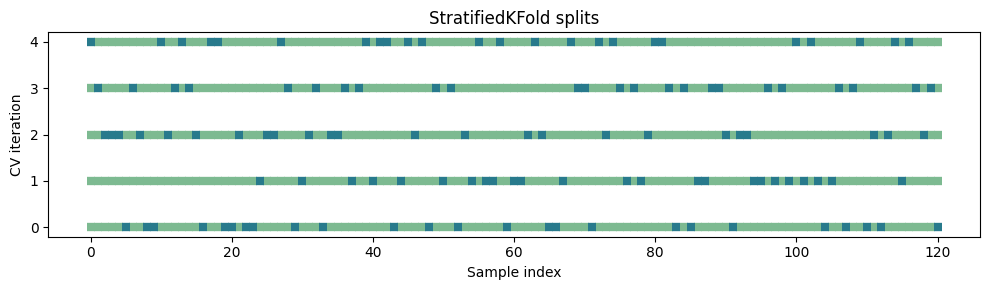

Fold 0: train=96, test=25
Fold 1: train=97, test=24
Fold 2: train=97, test=24
Fold 3: train=97, test=24
Fold 4: train=97, test=24
Fitting 5 folds for each of 11 candidates, totalling 55 fits

Cross-validation results:
                                      param_estimator  ...  std_test_score
4   MultiOutputClassifier(estimator=SVC(probabilit...  ...        0.114361
6   MultiOutputClassifier(estimator=SVC(probabilit...  ...        0.114361
9   MultiOutputClassifier(estimator=LogisticRegres...  ...        0.112977
10  MultiOutputClassifier(estimator=LogisticRegres...  ...        0.119887
8   MultiOutputClassifier(estimator=LogisticRegres...  ...        0.096325
3   MultiOutputClassifier(estimator=RandomForestCl...  ...        0.095543
2   MultiOutputClassifier(estimator=RandomForestCl...  ...        0.088018
1   MultiOutputClassifier(estimator=RandomForestCl...  ...        0.068988
0   MultiOutputClassifier(estimator=RandomForestCl...  ...        0.058579
7   MultiOutputClassifier(estima

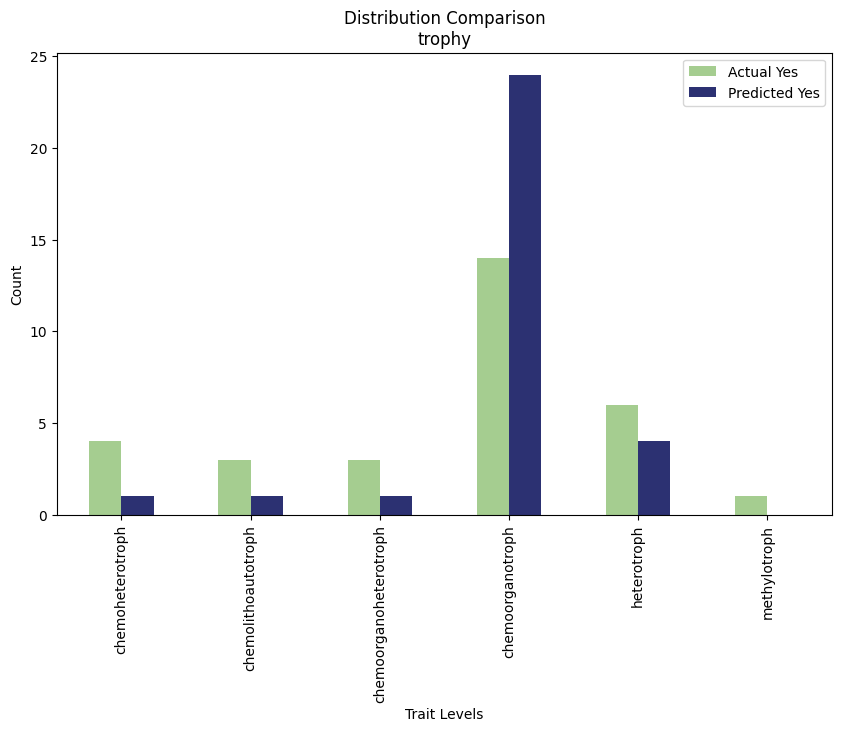

Sample mismatches:
Sample 11: Predicted 4, Max prob at 3


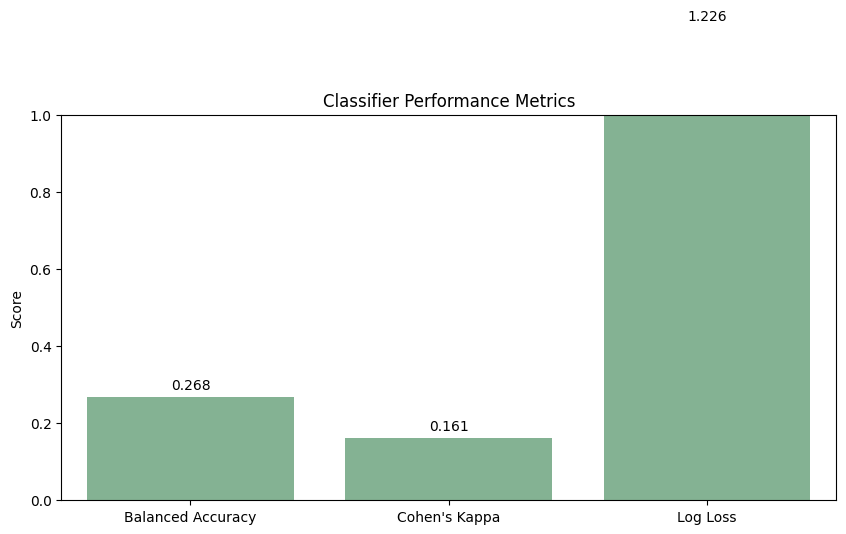

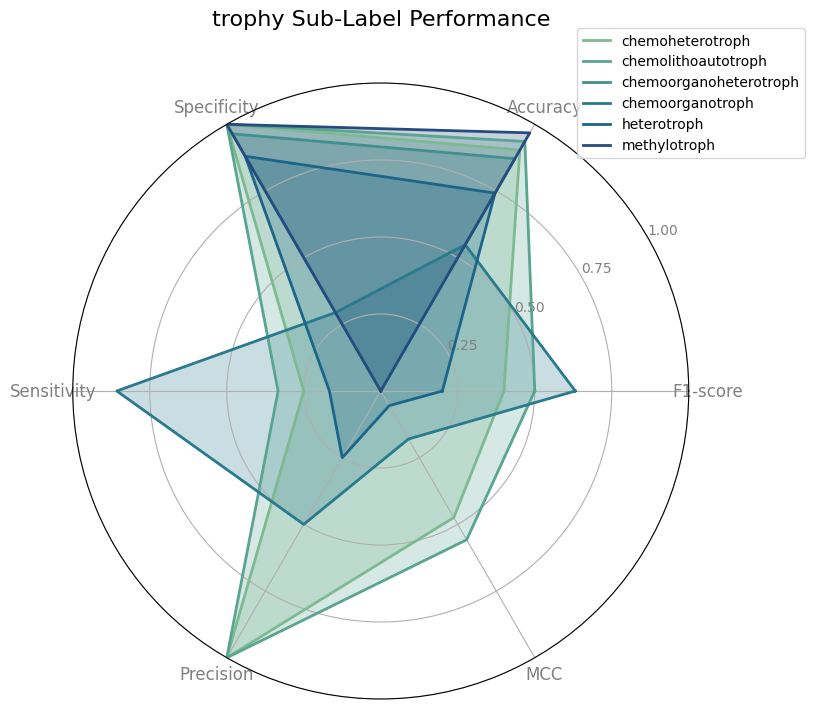

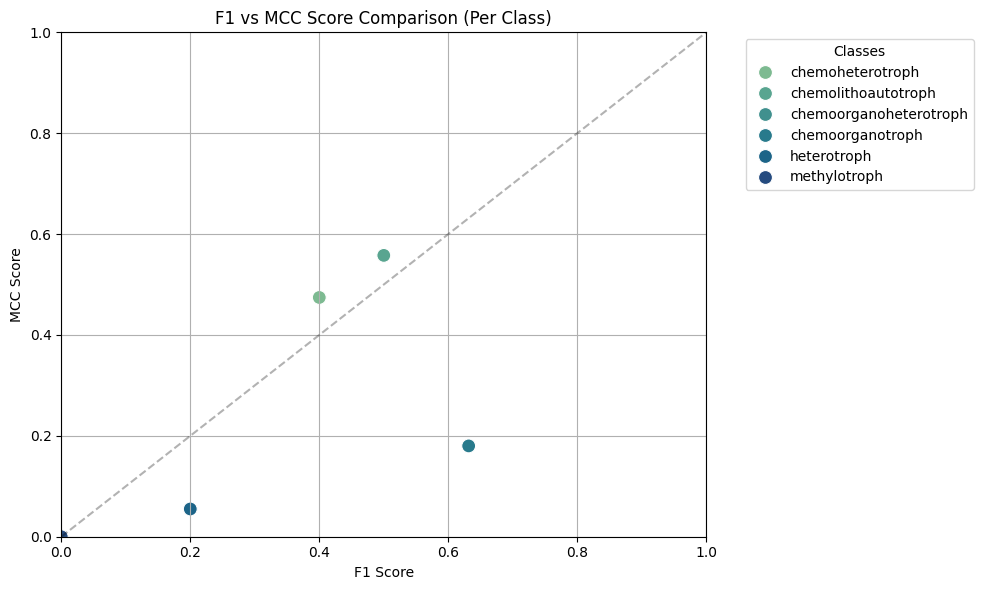


Classification Report (present classes only):
                        precision    recall  f1-score   support

      chemoheterotroph       1.00      0.25      0.40         4
   chemolithoautotroph       1.00      0.33      0.50         3
chemoorganoheterotroph       0.00      0.00      0.00         3
      chemoorganotroph       0.50      0.86      0.63        14
           heterotroph       0.25      0.17      0.20         6
          methylotroph       0.00      0.00      0.00         1

              accuracy                           0.48        31
             macro avg       0.46      0.27      0.29        31
          weighted avg       0.50      0.48      0.42        31



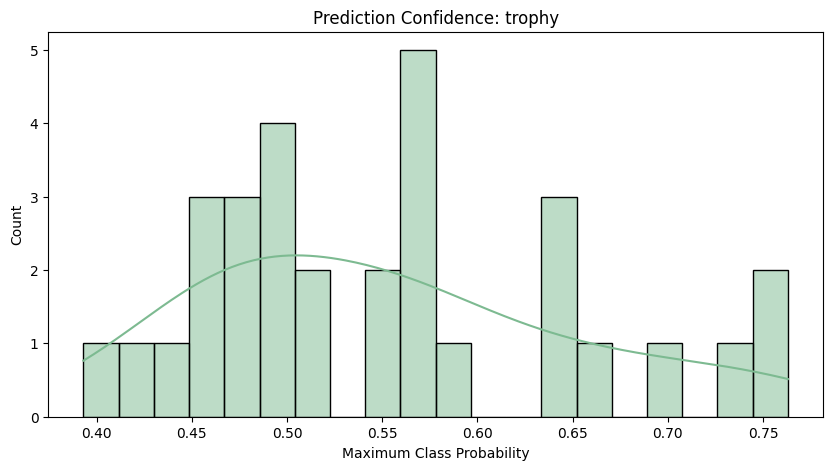

Mean confidence: 55.25%
Top-2 Accuracy: 70.97%
Found 2 ambiguous samples (Δprob < 0.1)


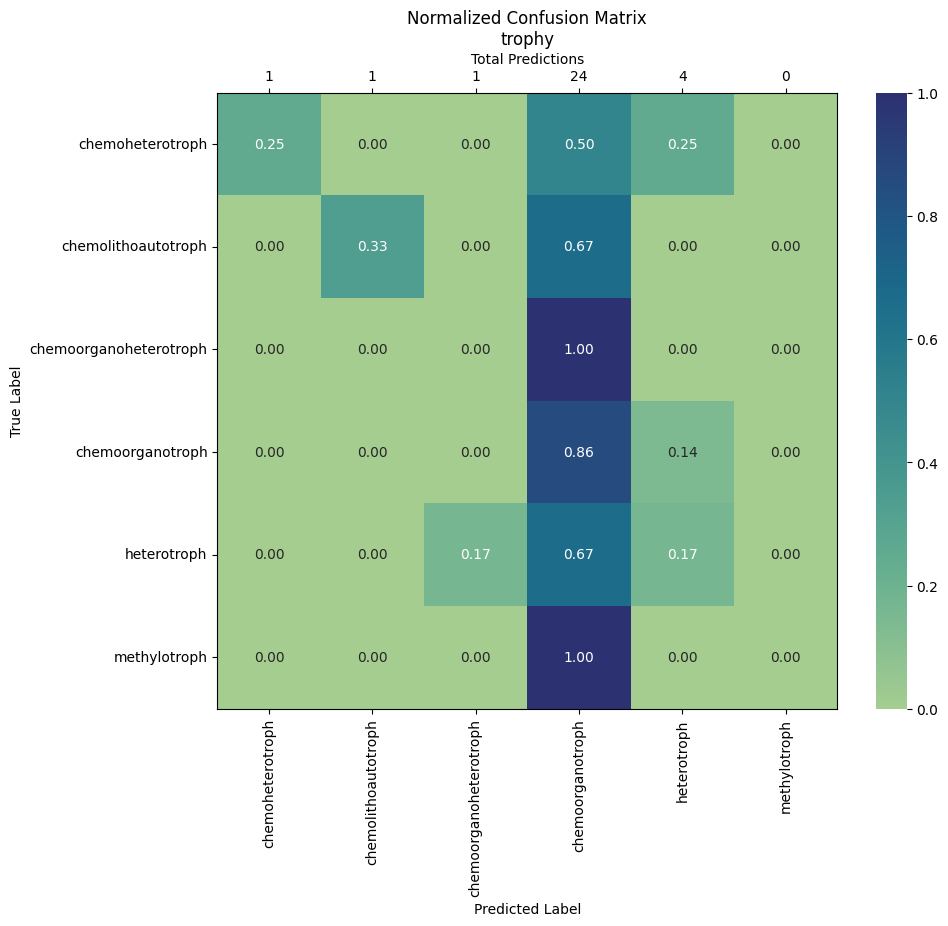

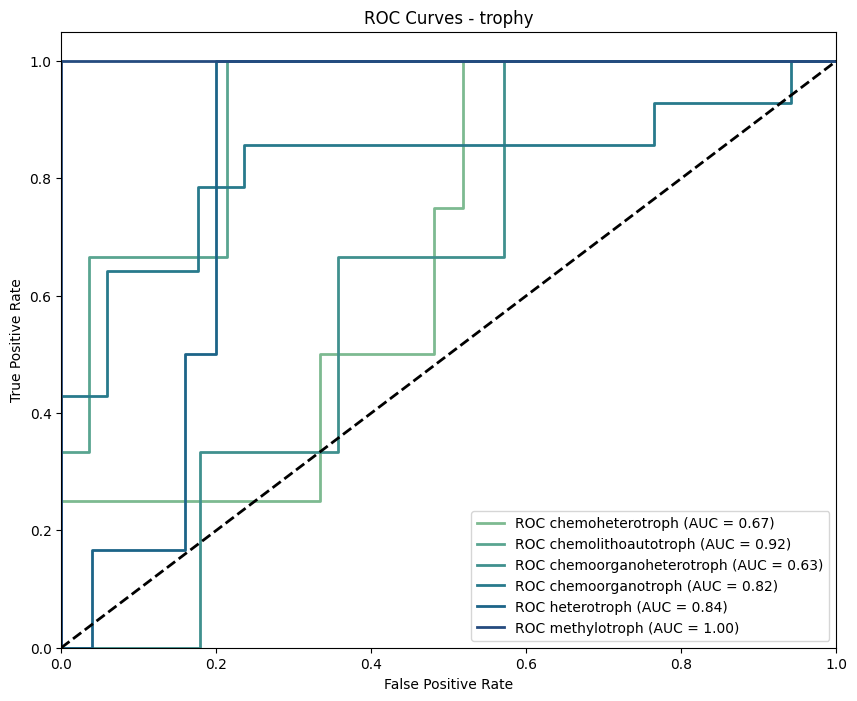

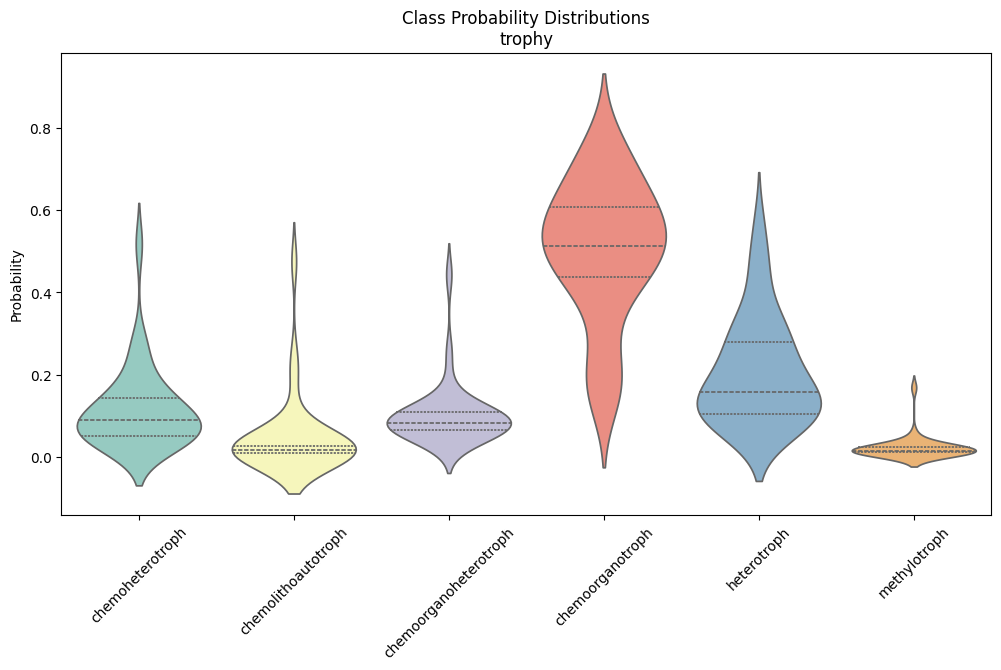

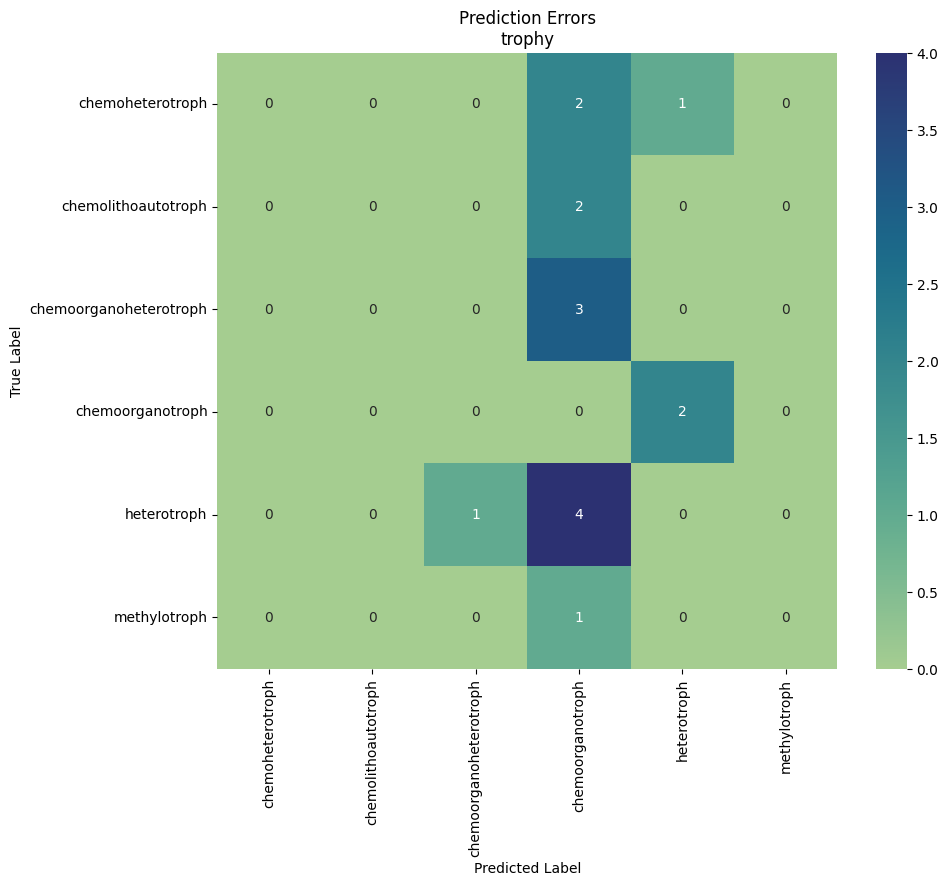

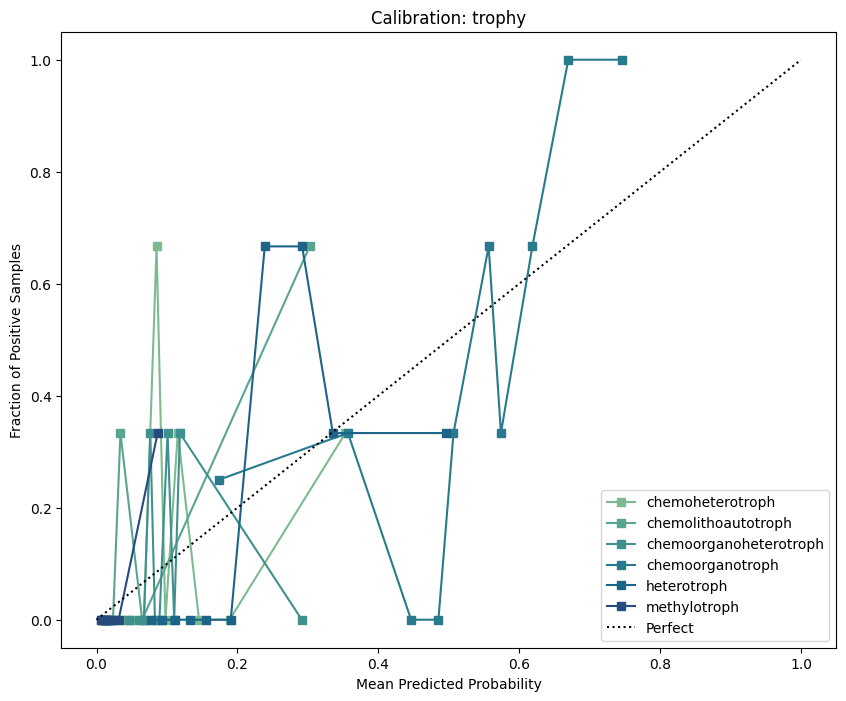

Brier Scores (Lower = Better):
                        Brier Score
chemoheterotroph           0.100996
chemolithoautotroph        0.063302
chemoorganoheterotroph     0.093890
chemoorganotroph           0.199956
heterotroph                0.131775
methylotroph               0.022713


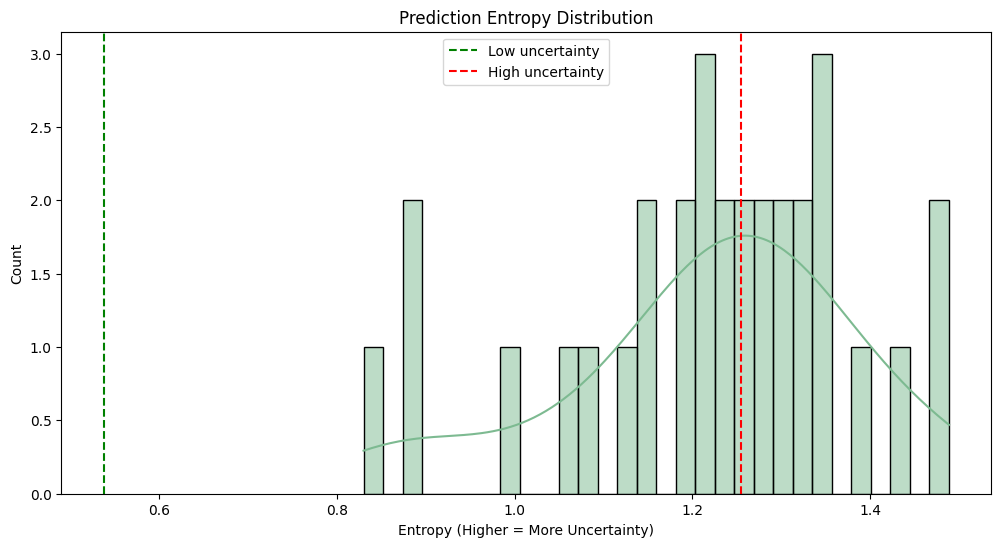

Found 14 highly uncertain predictions


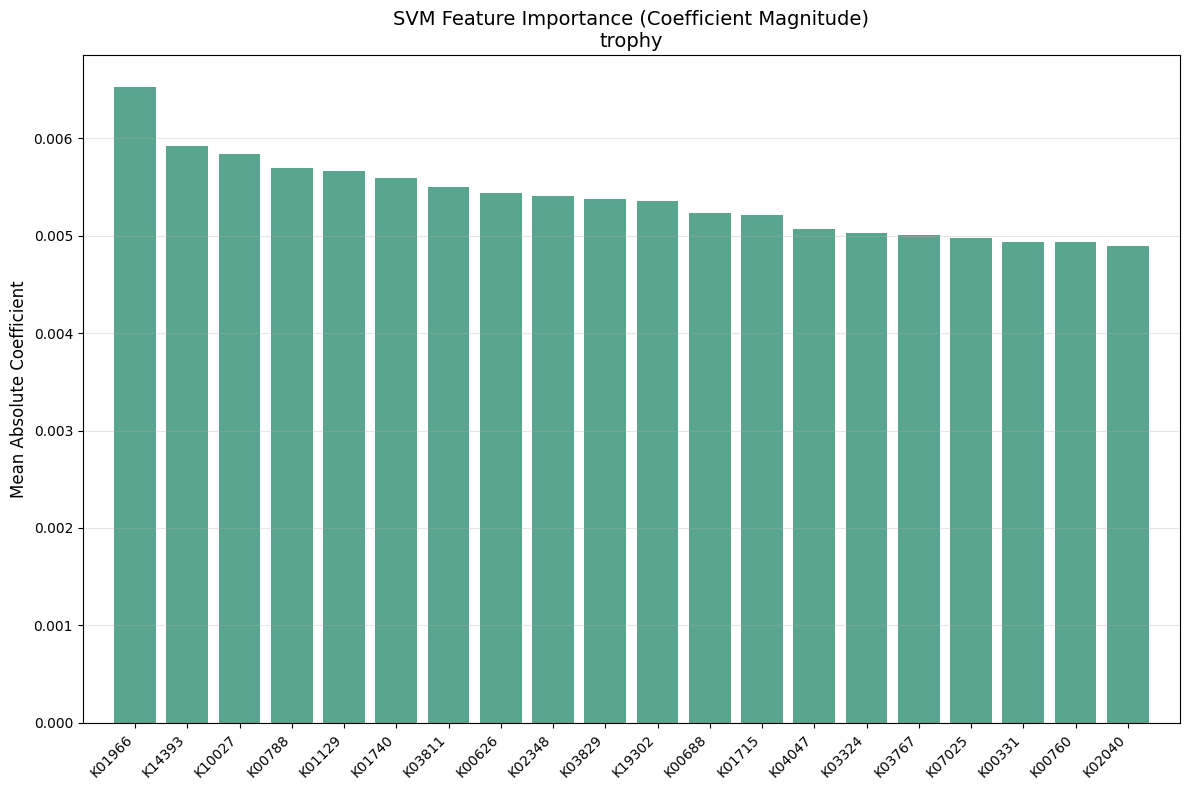

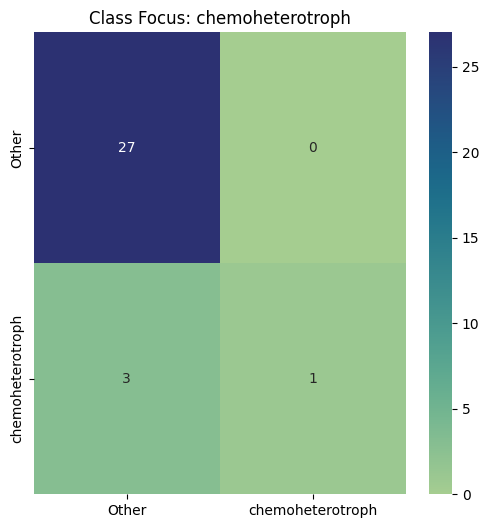

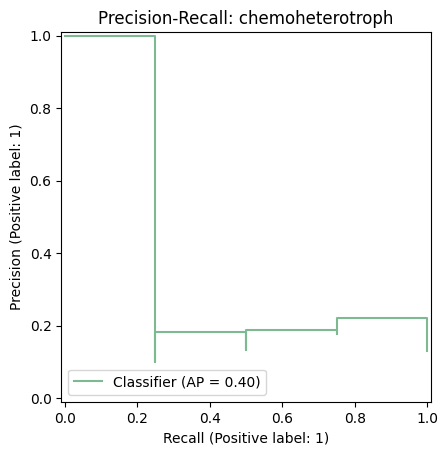

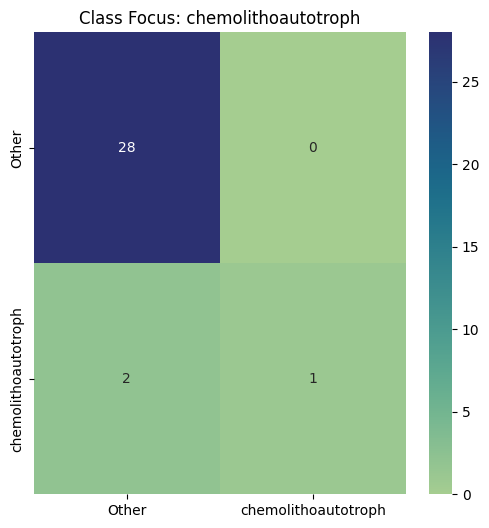

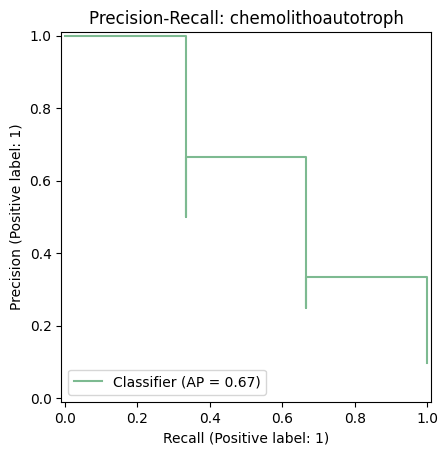

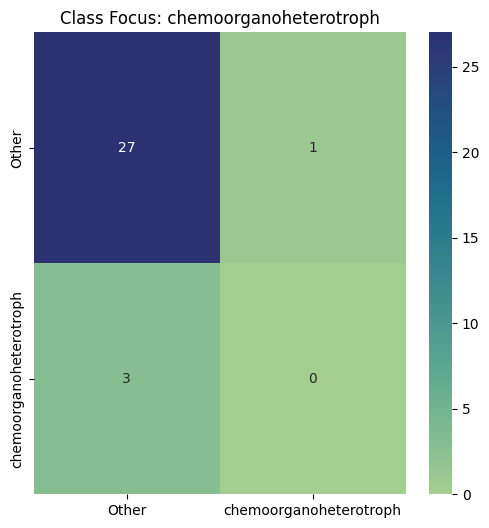

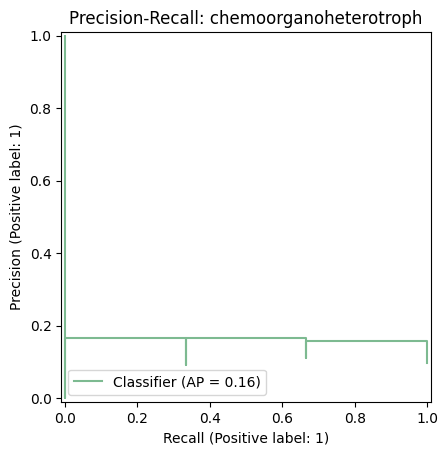

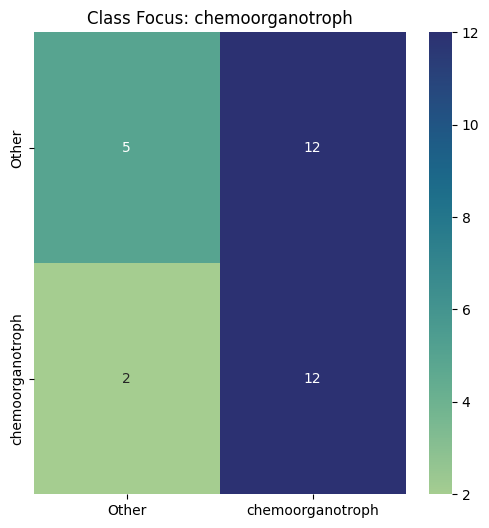

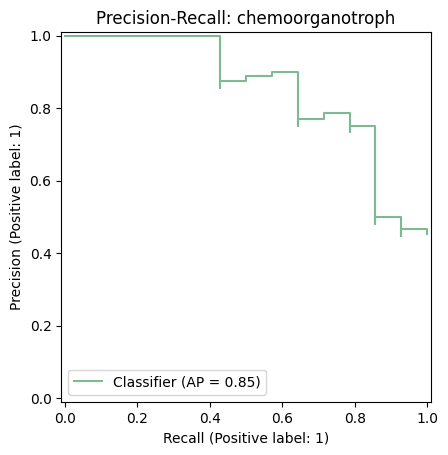

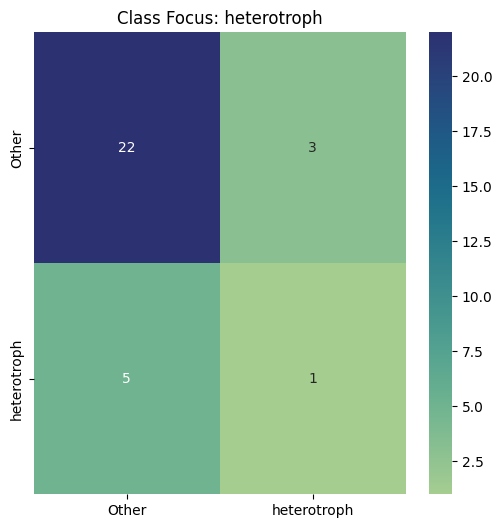

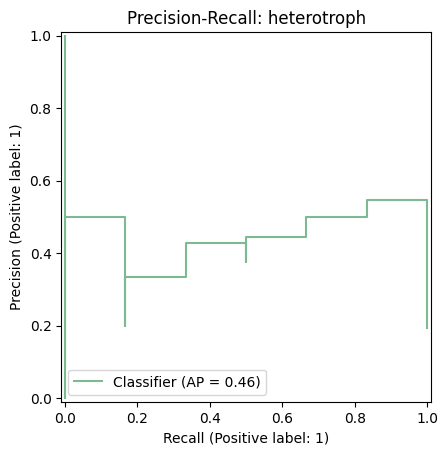

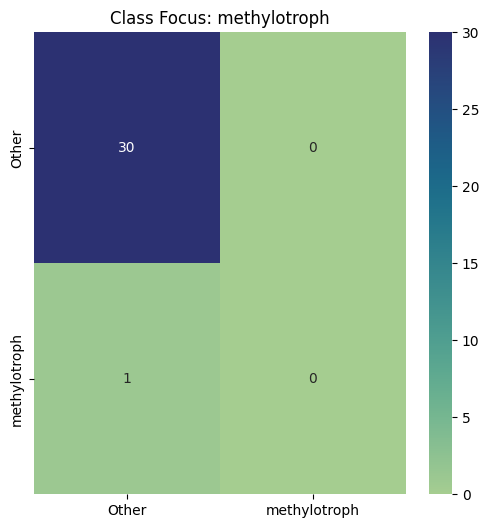

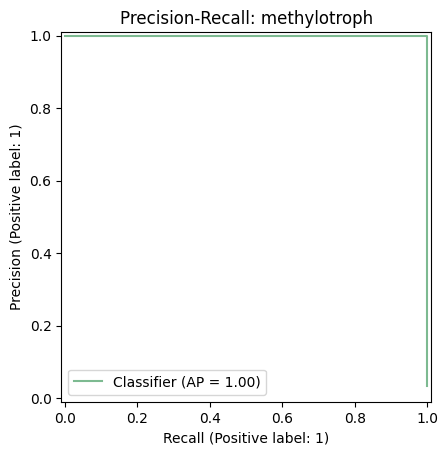


Completed evaluation for trophy

Evaluation complete for all traits


In [35]:
# Run the multiclass classification pipeline 
Results_model = train_and_evaluate_multitrait(
    X_aligned, 
    Y_aligned, 
    target_traits, 
    label_encoders,
    feature_names=selector.get_feature_names_out()  # From variance threshold
)

# Thoughts regarding the classification 

## 1. Advanced Confusion Matrix
**What it shows**:  
- Normalized prediction accuracy per class (rows sum to 1)  
- Raw prediction counts in bottom axis  

**Example**:  
For oxygen tolerance prediction:  
- 95% of true aerobes correctly predicted (row 1)  
- 10% of anaerobes misclassified as facultative (row 2, column 3)  

**Biological significance**:  
Identifies which microbial classes are frequently confused (e.g., facultative vs. microaerophilic)

---

## 2. ROC Curves & AUC Scores
**What it shows**:  
- True Positive Rate vs False Positive Rate for each class  
- AUC = Area Under Curve (1.0 = perfect, 0.5 = random)  

**Example**:  
Facultative class AUC=0.92 vs Anaerobic AUC=0.85 suggests better distinction of facultative organisms  

**Biological significance**:  
Measures how well KO terms separate different metabolic strategies

---

## 3. Class Probability Distributions
**What it shows**:  
- Distribution of predicted probabilities for each class  

**Example**:  
Narrow peak at 1.0 for "Gram-positive" shows high confidence  
Wide distribution for "Photolithotroph" indicates uncertainty  

**Biological significance**:  
Reveals ambiguous cases that might represent transitional phenotypes

---

## 4. Feature Importance
**What it shows**:  
- Top N most important KO terms for predictions  

**Example**:  
KO00010 (glycolysis) important for facultative prediction  

**Biological significance**:  
Identifies key metabolic pathways associated with specific traits

---

## 5. Prediction Error Analysis
**What it shows**:  
- Confusion between classes after removing correct predictions  

**Example**:  
Strong anaerobe↔facultative confusion suggests overlapping metabolic capabilities  

**Biological significance**:  
Highlights evolutionarily related traits that are hard to distinguish

---

## 6. Calibration Curves
**What it shows**:  
- Alignment of predicted probabilities with actual frequencies  

**Example**:  
At 0.8 predicted probability, 75% are actually positive  

**Biological significance**:  
Indicates whether probabilities can be trusted for rare phenotypes

---

## 7. Brier Scores
**What it shows**:  
- Mean squared error of probabilities (0=perfect, 1=worst)  

**Example**:  
Brier=0.12 for aerobes vs 0.25 for microaerophiles  

**Biological significance**:  
Identifies traits where genomic signatures are less distinct

---

## 8. Prediction Entropy
**What it shows**:  
- Uncertainty distribution across predictions  
- Thresholds: Low (<30% max), High (>70% max)  

**Example**:  
High entropy samples often match uncharacterized genomes  

**Biological significance**:  
Flags samples needing additional experimental validation

---

## 9. Confidence Distribution
**What it shows**:  
- Distribution of maximum class probabilities  

**Example**:  
Peak at 0.6-0.8 suggests conservative predictions  

**Biological significance**:  
Indicates overall model confidence in genome annotations

---

## 10. Ambiguous Samples
**What it shows**:  
- Samples where top-2 class probabilities differ by <0.1  

**Example**:  
Genome with 48% aerobic vs 45% facultative prediction  

**Biological significance**:  
Identifies potentially novel or transitional phenotypes

---

## 11. Metric Comparison
**What it shows**:  
- Balanced Accuracy: Performance on imbalanced classes  
- Cohen's Kappa: Agreement beyond chance  
- Log Loss: Probability calibration quality  

**Example**:  
High Kappa (>0.8) but moderate Log Loss (0.4) indicates good predictions with overconfident probabilities  

**Biological significance**:  
Holistic performance assessment for trait prediction reliability

# Key Questions to Answer:
### Are probabilities calibrated?
→ Check calibration curves & Brier scores

### Where is the model uncertain?
→ Entropy analysis + probability distributions

### Do errors make biological sense?
→ Confusion matrices between similar traits (e.g., facultative vs. microaerophilic)

### Can we trust high-confidence predictions?
→ Reliability diagrams for high-probability bins (>80%)


Interpretation:
- Excellent agreement beyond chance (Kappa > 0.75)
- Good handling of class imbalance (Balanced Acc > 0.8)
- 92% of predictions include true label in top-2 guesses
- Probability calibration is good (Log Loss < 0.5)


Feature Selection Analysis for trophy

Processing RandomForest...

Processing SVC...

Processing LogisticRegression...


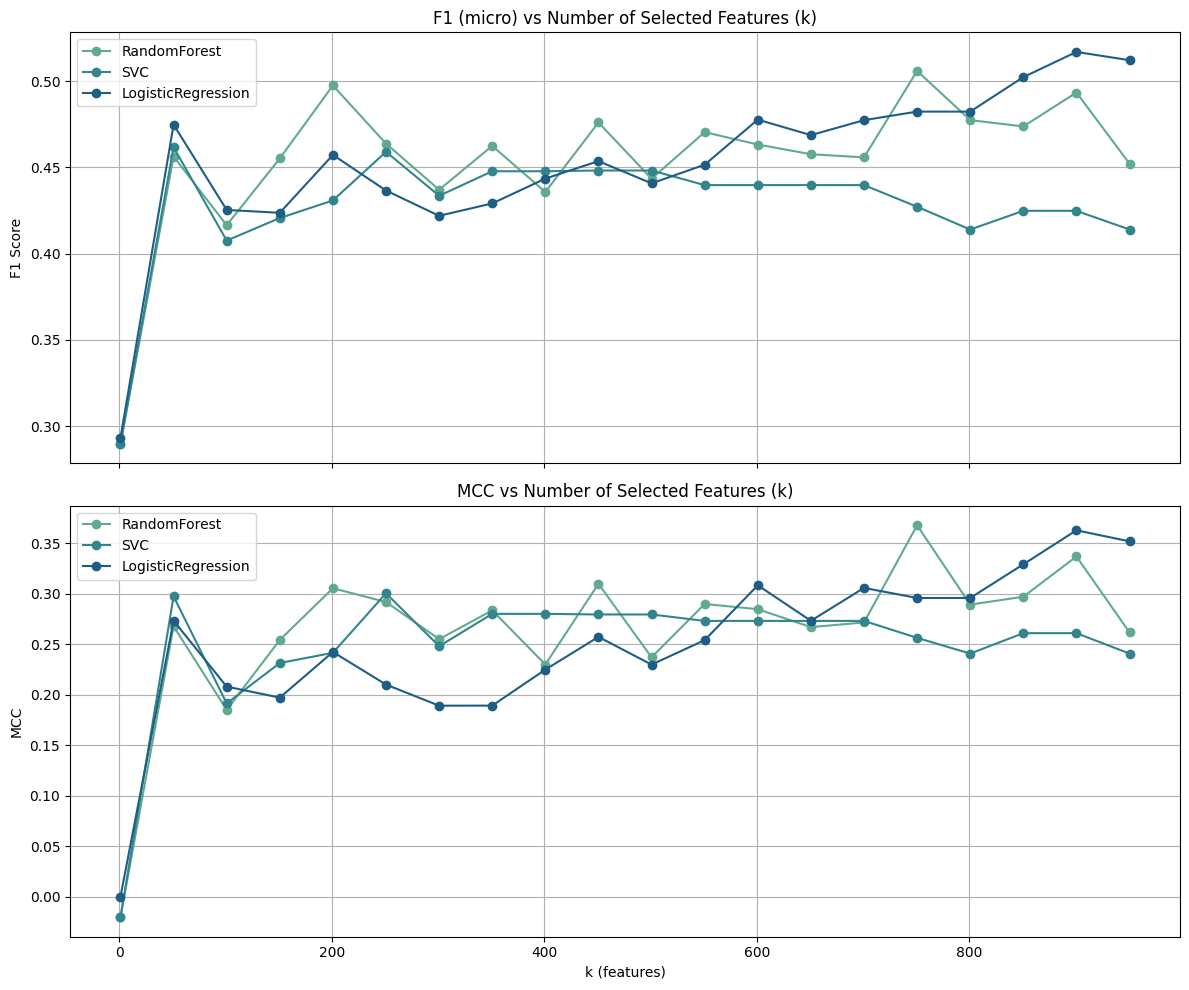

In [36]:
def run_feature_selection_analysis(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    estimator_configs = [
        {'name': 'RandomForest',      'estimator': RandomForestClassifier(random_state=42)},
        {'name': 'SVC',               'estimator': SVC(probability=True, random_state=42)},
        {'name': 'LogisticRegression','estimator': LogisticRegression()}
    ]

    results = {cfg['name']: {'f1': [], 'mcc': []} for cfg in estimator_configs}
    k_values = list(range(1, min(1000, X_train.shape[1]), 50))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    for cfg in estimator_configs:
        name = cfg['name']
        est  = cfg['estimator']
        print(f"\nProcessing {name}...")
        for k in k_values:
            pipe = Pipeline([
                ('select_k', SelectKBest(f_classif, k=k)),
                ('estimator',  est)
            ])
            f1 = cross_val_score(
                pipe, X_train, y_train, cv=cv,
                scoring=make_scorer(f1_score, average='weighted', zero_division=0),
                n_jobs=-1
            ).mean()
            mcc = cross_val_score(
                pipe, X_train, y_train, cv=cv,
                scoring=make_scorer(matthews_corrcoef),
                n_jobs=-1
            ).mean()
            results[name]['f1'].append(f1)
            results[name]['mcc'].append(mcc)

    # — now plot as two curves instead of a scatter —
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    colors = sns.color_palette("crest", n_colors=len(estimator_configs))

    for (name, scores), color in zip(results.items(), colors):
        axes[0].plot(k_values, scores['f1'], marker='o', color=color, label=name)
        axes[1].plot(k_values, scores['mcc'], marker='o', color=color, label=name)

    axes[0].set_title('F1 (micro) vs Number of Selected Features (k)')
    axes[0].set_ylabel('F1 Score')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].set_title('MCC vs Number of Selected Features (k)')
    axes[1].set_xlabel('k (features)')
    axes[1].set_ylabel('MCC')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

for trait in target_traits:
    print(f"\n{'='*40}\nFeature Selection Analysis for {trait}\n{'='*40}")
    run_feature_selection_analysis(X_aligned, Y_aligned[trait])

In [37]:
from bioservices import KEGG
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network

# ----------------------------------------
# 1) Extract top‐N important KOs from your trained model
# ----------------------------------------
def get_top_kos_for_trait(best_model, feature_names, label_encoders, target_traits, top_n=50):
    """
    Returns a dict mapping each trait -> list of top N KO feature names.
    """
    top_kos = {}
    for idx, trait in enumerate(target_traits):
        # RandomForest inside MultiOutputClassifier
        rf = best_model.named_steps['estimator'].estimators_[idx]
        if not hasattr(rf, "feature_importances_"):
            raise ValueError(f"Estimator for '{trait}' has no feature_importances_")

        importances = rf.feature_importances_
        # sort descending and take top_n
        top_idx = np.argsort(importances)[::-1][:top_n]
        top_features = feature_names[top_idx]
        top_kos[trait] = top_features.tolist()
    return top_kos

# Example usage (after training):
# ----
# feature_names = np.array(feature_names)  # ensure numpy array for indexing
# top_kos = get_top_kos_for_trait(best_model, feature_names, label_encoders, target_traits, top_n=30)
# selected_kos = top_kos['oxygen']
# ----


# ----------------------------------------
# 2) Map those selected KOs to KEGG pathways
# ----------------------------------------
def map_ko_to_pathways(ko_list):
    """
    Given an iterable of KO IDs (e.g. ['K00001','K00002',...]),
    returns a dict pathway_id -> set(of KO IDs).
    """
    kegg = KEGG()
    pathways = {}
    for ko in ko_list:
        try:
            links = kegg.link("pathway", ko)
        except Exception as e:
            print(f"KEGG lookup failed for {ko}: {e}")
            continue

        if not links:
            continue

        for line in links.strip().split("\n"):
            ko_id, path_id = line.split("\t")
            pathways.setdefault(path_id, set()).add(ko)
    return pathways


# ----------------------------------------
# 3) Build and visualize the adjacency matrix
# ----------------------------------------
def build_pathway_matrix(selected_kos, translated_kos=None):
    """
    Returns a DataFrame: rows = KOs (with optional human‐readable labels),
    columns = pathway IDs.
    """
    # placeholder translations if none provided
    if translated_kos is None:
        translated_kos = {ko: ko for ko in selected_kos}

    pathways = map_ko_to_pathways(selected_kos)
    # DataFrame scaffold
    idx_labels = [f"{translated_kos[ko]} ({ko})" for ko in selected_kos]
    mat = pd.DataFrame(0, index=idx_labels, columns=pathways.keys(), dtype=int)

    for path_id, kos in pathways.items():
        for ko in kos:
            label = f"{translated_kos[ko]} ({ko})"
            mat.at[label, path_id] = 1

    return mat

# ----------------------------------------
# 4) Replace IDs with human‐readable pathway names
# ----------------------------------------
def rename_pathway_columns(mat):
    kegg = KEGG()
    new_cols = {}
    for path_id in mat.columns:
        try:
            info = kegg.get(path_id)
            parsed = kegg.parse(info)
            name = parsed.get('NAME', [''])[0]
            new_cols[path_id] = name or path_id
        except Exception:
            new_cols[path_id] = path_id
    return mat.rename(columns=new_cols)

# ----------------------------------------
# 5) Plot heatmap and interactive network
# ----------------------------------------
def visualize_pathway_matrix(mat, title="KO vs KEGG Pathways"):
    plt.figure(figsize=(12, max(6, len(mat)*0.3)))
    sns.heatmap(mat, annot=True, cmap="crest", cbar=False)
    plt.title(title)
    plt.xlabel("Pathways")
    plt.ylabel("KO Terms")
    plt.tight_layout()
    plt.show()

def visualize_network(mat, exclude_general=None):
    """
    Build a bipartite network (KO <-> Pathway) and display via PyVis.
    """
    if exclude_general is None:
        exclude_general = set()

    G = nx.Graph()
    # add KO nodes
    for ko_label in mat.index:
        G.add_node(ko_label, label=ko_label, color='red', size=15, group='KO')

    # add pathways
    for pathway_name in mat.columns:
        if pathway_name.lower() in exclude_general:
            continue
        G.add_node(pathway_name, label=pathway_name, color='blue', size=25, group='Pathway')
        # edges
        for ko_label, val in mat[pathway_name].iteritems():
            if val:
                G.add_edge(ko_label, pathway_name)

    net = Network(height="800px", width="100%", notebook=True,
                  heading=title, bgcolor="#ffffff", font_color="black")
    net.from_nx(G)
    net.toggle_physics(True)
    net.show_buttons(filter_=['physics'])
    return net

# ----------------------------------------
# 6) Putting it all together
# ----------------------------------------
# after you fit best_model and have feature_names, label_encoders, target_traits:

# 1. Get top KOs for 'oxygen'
top_kos = get_top_kos_for_trait(best_model,
                                np.array(feature_names),
                                label_encoders,
                                target_traits,
                                top_n=30)

selected_kos = top_kos['oxygen']

# 2. (Optional) supply your own translations:
translated_kos = {ko: ko.replace("K","KEGG_") for ko in selected_kos}

# 3. Build & rename the matrix
raw_mat = build_pathway_matrix(selected_kos, translated_kos=translated_kos)
mat = rename_pathway_columns(raw_mat)

print("Adjacency matrix of top KOs vs. KEGG pathways:\n", mat)

# 4. Visualize
visualize_pathway_matrix(mat, title="Top-30 Oxygen KOs ↔ KEGG Pathways")
net = visualize_network(mat, exclude_general={"metabolic pathways"})
net.show("ko_pathway_network.html")


NameError: name 'best_model' is not defined